In [1]:
import json
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

In [2]:
from ace_extraction import load_dataset_and_tagger
from infonet.evaluation import mention_relation_stats, mention_boundary_stats

In [3]:
model_f = 'tagger_bi_50_100_linear_0.5_100_100_0.0001_2_glove.6B.200d.txt'
for i, line in enumerate(open('experiments/'+model_f+'_report_stats.json', 'r')):
    if i > 0:
        break
    report_stats = json.loads(line)
    
    
# line = open('experiments/'+model_f+'_report_stats.json', 'r').readlines()[-1]
# report_stats = json.loads(line)

In [5]:
print report_stats['reports'][0].keys()

[u'pos_embed/W/data', u'crf/uni_bias/grad', u'out/W/data', u'logit/W/data', u'out/b/data', u'lstm_0/b_WU_r/grad', u'lstm_0/f_b_r/grad', u'lstm_0/b_b_r/grad', u'crf/trans_cost/grad', u'mlp/W/grad', u'pos_embed/W/grad', u'lstm_0/b_b_z/data', u'lstm_0/b_b_r/data', u'lstm_0/f_WU_z/grad', u'mlp/b/grad', u'crf/uni_cost/grad', u'crf/trans_bias/data', u'lstm_0/f_WU_r/grad', u'lstm_0/f_WU_h/data', u'lstm_0/f_WU_r/data', u'logit/W/grad', u'out/W/grad', u'crf/trans_cost/data', u'lstm_0/b_WU_z/grad', u'lstm_0/b_WU_r/data', u'lstm_0/f_b_r/data', u'lstm_0/f_b_z/grad', u'crf/uni_bias/data', u'lstm_0/b_WU_z/data', u'lstm_0/f_b_z/data', u'out/b/grad', u'logit/b/data', u'lstm_0/f_WU_z/data', u'embed/W/grad', u'lstm_0/b_b_h/grad', u'lstm_0/f_WU_h/grad', u'mlp/W/data', u'lstm_0/b_b_h/data', u'crf/uni_cost/data', u'lstm_0/b_WU_h/grad', u'embed/W/data', u'lstm_0/f_b_h/data', u'mlp/b/data', u'logit/b/grad', u'lstm_0/f_b_h/grad', u'lstm_0/b_b_z/grad', u'lstm_0/b_WU_h/data', u'crf/trans_bias/grad']


In [ ]:
print sorted(dev_stats.keys())

In [6]:
print len(dev_stats['m_trues'])

80


### How to view errors?

* Given list of docs, aggregate over them
* Show confusion matrix
* For entities, event anchors, relations, and event args do:
* Enumerate over mention types, the relation types
    * Sort mentions by nodetype, mtype
    * Sort relations by reltype, rsubtype name, direction
* Report the class-specific f1 stats and its rank within group
* Show false negatives and their concordance
* Then take all false positives that don't overlap the false negatives and display these
* Report the mention width, and widths and distances for relations
* Report the NULL percentage
* Report the percentage of errors due to boundary predictions vs misclassifications
    * NOTE: This is typically atleast > 50% boundary errors for mentions.  Need to get this higher.


### Types of errors:

#### Mentions:
* Should have been a mention, but we didn't predict the boundary correctly (it overlaps or is non-existent)
* We predicted a boundary that is totally spurious - it doesn't overlap a true boundary at all
* We got the boundary correct, but mispredicted the class

#### Relations:
* Should have been a relation, but we didn't predict one or both of the mention boundaries correctly
* Should have been a relatio

In [7]:
entity_keys = sorted([k for k in dev_stats.keys() if k.startswith('entity')])
eventanchor_keys = sorted([k for k in dev_stats.keys() if k.startswith('event-anchor')])
def edge_sortkey(edgename):
    edgename = ':'.join(edgename.split(':')[1:])
    direction, edgename = edgename[:2], edgename[2:]
    return edgename, direction
relation_keys = sorted([k for k in dev_stats.keys() if 'relation' in k], key=edge_sortkey)
eventarg_keys = sorted([k for k in dev_stats.keys() if 'event-argument' in k], key=edge_sortkey)

In [8]:
def error_analysis(stats, start=0, end=None, context=7):
    if end is None:
        end = len(stats)

    # for confusion matrices
    node_map = {}
    for i,k in enumerate(entity_keys+eventanchor_keys):
        node_map[k] = i
    edge_map = {}
    for i,k in enumerate(relation_keys+eventarg_keys+['--NULL--', 'coreference:--SameAs--']):
        edge_map[k] = i
    # confusion matrix
    # we consider classification confusion, only when the boundaries are correct
    node_cm = np.zeros((len(node_map.keys()), len(node_map.keys())))


    # get all of the examples of errors
    examples = {k:{'fns':[], 'fps':[], 'tps':[], 'miss':[], 'fn':0, 'fp':0, 'tp':0}
                for k in node_map.keys()+edge_map.keys()}
    zipped = zip(stats['xs'][start:end], 
                 stats['b_trues'][start:end], 
                 stats['b_preds'][start:end], 
                 stats['m_trues'][start:end], 
                 stats['m_preds'][start:end])
    for doc_i, (xs, btrues, bpreds, mtrues, mpreds) in enumerate(zipped):
    #     print "*** Document {} ****************************************".format(start+doc_i)
        truespans = {tuple(m[:2]) for m in mtrues}
        predspans = {tuple(m[:2]) for m in mpreds}
        true2type = {tuple(m[:2]):m[2] for m in mtrues}
        pred2type = {tuple(m[:2]):m[2] for m in mpreds}
    #     mtrues, mpreds = {tuple(m) for m in mtrues}, {tuple(m) for m in mpreds}
        fnspans = truespans - predspans
        fpspans = predspans - truespans
        tpspans = truespans & predspans
        assert (fnspans | fpspans | tpspans) == (truespans | predspans) 
        # all predicted spans that overlap with each true span
        overlaps = {s:[p for p in predspans 
                       if (p[0] >= s[0] and p[0] < s[1]) 
                       or (p[1] > s[0] and p[1] <= s[1])]
                    for s in truespans}

        # all mentions that should have been predicted, but were missed
        seenfps = set({})
        for m in fnspans:
            fps = overlaps[m]
            # remove overlapping fps from fpspans, so that looking at fps gives spurious only
            fpspans -= set(fps)
            span = (m[0]-context, m[1]+context+1)

            x = xs[span[0]:span[1]]
            indices = range(span[0], span[1])
            idxs = ["{: ^{}}".format(str(b)[-len(t):], len(t)) for b,t in zip(indices, x)]
            bt = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(btrues[span[0]:span[1]], x)]
            bp = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(bpreds[span[0]:span[1]], x)]
            mlen = len(" ".join(x[context:context+m[1]-m[0]]))
            mt = [" ".join(['-'*len(t) for t in x[:context]]), 
                  "{:~^{}}".format(true2type[m][-mlen:], mlen), 
                  " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
                  ]
            mp = ['-'*len(t) for t in x]

            # add context delimiters
            x.insert(context, '[')
            x.insert(context+m[1]-m[0]+1, ']')
            indices.insert(context, '[')
            indices.insert(context+m[1]-m[0]+1, ']')
            idxs.insert(context, '[')
            idxs.insert(context+m[1]-m[0]+1, ']')
            bt.insert(context, '[')
            bt.insert(context+m[1]-m[0]+1, ']')
            bp.insert(context, '[')
            bp.insert(context+m[1]-m[0]+1, ']')
            mt.insert(1, '[')
            mt.insert(3, ']')
            mp.insert(context, '[')
            mp.insert(context+m[1]-m[0]+1, ']')

            # format false positives for this mention
            offset = 0
            max_i = max([i for i in indices if type(i) is int])
            min_i = min([i for i in indices if type(i) is int])
            for j, fp in enumerate(sorted(fps, key=lambda x:x[0])):
                fp0, fp1 = fp
                if fp1 > max_i: fp1 = max_i
                if fp0 < min_i: fp0 = min_i
                s, e = indices.index(fp0), indices.index(fp1)
                s -= offset
                e -= offset
                t = pred2type[fp]
                if j == len(fps)-1:
    #                 print fp, m
                    if fp1 > m[1]: # handle the trailing ']' for fps that overflow true boundary
                        pass
                    elif e-1 == s:
                        pass
                    else:
                        e -= 1
                t_wid = len(" ".join(mp[s:e]))
                mp[s:e] = ['{:~^{}}'.format(t[-t_wid:], t_wid)]
                offset += e-s-1
                if fp not in seenfps:
                    examples[pred2type[fp]]['fp'] += 1
                seenfps |= {fp}

            # add to examples:
            example = {
                'indices':idxs,
                'mention tokens':xs[m[0]:m[1]],
                'tokens':x,
                'b trues':bt,
                'b preds':bp,
                'm true': mt,
                'm preds':mp,
                'm true len':m[1]-m[0],
                'm pred types':[pred2type[t] for t in fps]
            }
            examples[true2type[m]]['fns'].append(example)
            examples[true2type[m]]['fn'] += 1
    #         print
    #         print "indices: ... {} ...".format(" ".join(idxs))
    #         print "tokens:  ... {} ...".format(" ".join(x))
    #         print "b trues: ... {} ...".format(" ".join(bt))
    #         print "b preds: ... {} ...".format(" ".join(bp))
    #         print "m true : ... {} ...".format(" ".join(mt))
    #         print "m preds: ... {} ...".format(" ".join(mp))

        # all mentions that were totally spurious
        for m in fpspans:
            m = (int(m[0]), int(m[1]))
            span = (m[0]-context, m[1]+context+1)
    #         print 

            x = xs[span[0]:span[1]]
            indices = range(span[0], span[1])
            idxs = ["{: ^{}}".format(str(b)[-len(t):], len(t)) for b,t in zip(indices, x)]
            bt = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(btrues[span[0]:span[1]], x)]
            bp = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(bpreds[span[0]:span[1]], x)]
            mlen = len(" ".join(x[context:context+m[1]-m[0]]))
    #         mt = [" ".join(['-'*len(t) for t in x[:context]]), 
    #               "{:~^{}}".format(true2type[m][-mlen:], mlen), 
    #               " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
    #               ]
    #         mp = ['-'*len(t) for t in x]

            # add context delimiters
            x.insert(context, '[')
            x.insert(context+m[1]-m[0]+1, ']')
            indices.insert(context, '[')
            indices.insert(context+m[1]-m[0]+1, ']')
            idxs.insert(context, '[')
            idxs.insert(context+m[1]-m[0]+1, ']')
            bt.insert(context, '[')
            bt.insert(context+m[1]-m[0]+1, ']')
            bp.insert(context, '[')
            bp.insert(context+m[1]-m[0]+1, ']')
    #         mt.insert(1, '[')
    #         mt.insert(3, ']')
    #         mp.insert(context, '[')
    #         mp.insert(context+m[1]-m[0]+1, ']')

            # add to examples:
            example = {
                'indices':idxs,
                'tokens':x,
                'mention tokens':xs[m[0]:m[1]],
                'b trues':bt,
                'b preds':bp,
            }
            examples[pred2type[m]]['fps'].append(example)
            examples[pred2type[m]]['fp'] += 1
        # all mentions with the correct spans
        for m in tpspans:
            m = (int(m[0]), int(m[1]))
            span = (m[0]-context, m[1]+context+1)

            x = xs[span[0]:span[1]]
            indices = range(span[0], span[1])
            idxs = ["{: ^{}}".format(str(b)[-len(t):], len(t)) for b,t in zip(indices, x)]
            bt = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(btrues[span[0]:span[1]], x)]
            bp = ["{: ^{}}".format(b[:len(t)], len(t)) for b,t in zip(bpreds[span[0]:span[1]], x)]
            mlen = len(" ".join(x[context:context+m[1]-m[0]]))+4
            mt = [" ".join(['-'*len(t) for t in x[:context]]), 
                  "{:~^{}}".format(true2type[m][-mlen:], mlen), 
                  " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
                  ]
            mp = [" ".join(['-'*len(t) for t in x[:context]]), 
                  "{:~^{}}".format(pred2type[m][-mlen:], mlen), 
                  " ".join(['-'*len(t) for t in x[context+m[1]-m[0]:]])
                  ]

            # add context delimiters
            x.insert(context, '[')
            x.insert(context+m[1]-m[0]+1, ']')
            indices.insert(context, '[')
            indices.insert(context+m[1]-m[0]+1, ']')
            idxs.insert(context, '[')
            idxs.insert(context+m[1]-m[0]+1, ']')
            bt.insert(context, '[')
            bt.insert(context+m[1]-m[0]+1, ']')
            bp.insert(context, '[')
            bp.insert(context+m[1]-m[0]+1, ']')
            mt.insert(context, '[')
            mt.insert(context+m[1]-m[0]+1, ']')
            mp.insert(context, '[')
            mp.insert(context+m[1]-m[0]+1, ']')

    #         print
    #         print "True:{}, Pred:{}".format(true2type[m], pred2type[m])
    #         print "indices: ... {} ...".format(" ".join(idxs))
    #         print "tokens:  ... {} ...".format(" ".join(x))
    #         print "b trues: ... {} ...".format(" ".join(bt))
    #         print "b preds: ... {} ...".format(" ".join(bp))
    #         print "m true : ... {} ...".format(" ".join(mt))
    #         print "m preds: ... {} ...".format(" ".join(mp))

            # add to examples:
            example = {
                'indices':idxs,
                'tokens':x,
                'mention tokens':xs[m[0]:m[1]],
                'b trues':bt,
                'b preds':bp,
                'm true': mt,
                'm preds':mp,
                'm true len':m[1]-m[0],
                'm pred type':pred2type[m]
            }
            node_cm[node_map[true2type[m]], node_map[pred2type[m]]] += 1
            if true2type[m] == pred2type[m]:
                examples[true2type[m]]['tps'].append(example)
                examples[true2type[m]]['tp'] += 1
#                 examples[pred2type[m]]['tp'] += 1
            else:
                examples[true2type[m]]['miss'].append(example)
                examples[true2type[m]]['fn'] += 1
                examples[pred2type[m]]['fp'] += 1

    # get class specific f1s
    for k in node_map.keys():
        examples[k]['support'] = examples[k]['tp'] + examples[k]['fp'] + examples[k]['fn']
        examples[k]['precision'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fp'] + 1e-15)
        examples[k]['recall'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fn'] + 1e-15)
        examples[k]['f1'] = (2*examples[k]['precision']*examples[k]['recall']
                             /(examples[k]['precision']+examples[k]['recall']+1e-15))

    # nodetype f1s
    for k in entity_keys:
        examples['entity']['tp'] += examples[k]['tp']
        examples['entity']['fp'] += examples[k]['fp']
        examples['entity']['fn'] += examples[k]['fn']
        examples['entity']['fns'].extend(examples[k]['fns'])
        examples['entity']['fps'].extend(examples[k]['fps'])
        examples['entity']['miss'].extend(examples[k]['miss'])
    k = 'entity'
    examples[k]['support'] = examples[k]['tp'] + examples[k]['fp'] + examples[k]['fn']
    examples[k]['precision'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fp'] + 1e-15)
    examples[k]['recall'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fn'] + 1e-15)
    examples[k]['f1'] = (2*examples[k]['precision']*examples[k]['recall']
                             /(examples[k]['precision']+examples[k]['recall']+1e-15))

    for k in eventanchor_keys:
        examples['event-anchor']['tp'] += examples[k]['tp']
        examples['event-anchor']['fp'] += examples[k]['fp']
        examples['event-anchor']['fn'] += examples[k]['fn']
        examples['event-anchor']['fns'].extend(examples[k]['fns'])
        examples['event-anchor']['fps'].extend(examples[k]['fps'])
        examples['event-anchor']['miss'].extend(examples[k]['miss'])
    k = 'event-anchor'
    examples[k]['support'] = examples[k]['tp'] + examples[k]['fp'] + examples[k]['fn']
    examples[k]['precision'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fp'] + 1e-15)
    examples[k]['recall'] = examples[k]['tp'] / (examples[k]['tp'] + examples[k]['fn'] + 1e-15)
    examples[k]['f1'] = (2*examples[k]['precision']*examples[k]['recall']
                             /(examples[k]['precision']+examples[k]['recall']+1e-15))
    
    examples['node_cm'] = node_cm
    examples['node_map'] = node_map
    return examples
#         print 
#         print "indices: ... {} ...".format(" ".join(idxs))
#         print "tokens:  ... {} ...".format(" ".join(x))
#         print "b trues: ... {} ...".format(" ".join(bt))
#         print "b preds: ... {} ...".format(" ".join(bp))

# Todo next:

* also calculate type-specific f1s by true mention
* convert above cell to a function that returns the examples given limits and context size
* create function that outputs errors in meaningful order
* create function that creates confusion matrices
* categorize error proportions by boundary fn, fp, and misclassification percentages

* do the same for relations



In [9]:
examples = error_analysis(dev_stats, context=15)

/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


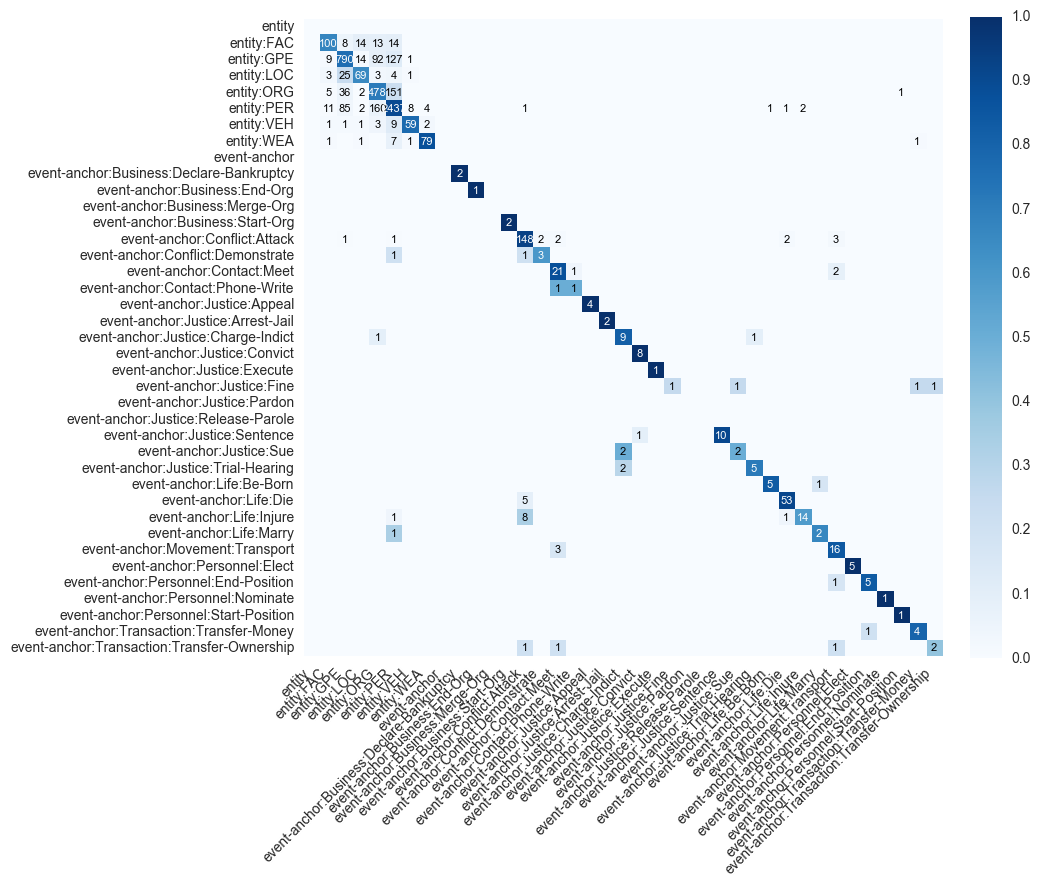

In [10]:
def plot_cm(cm, cm_map, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(1, figsize=(9,9))
#     im = ax.imshow(cm, interpolation='nearest', aspect='auto', cmap='jet')
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > .5 else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, size=8)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#     divider = plt.make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    a = [t-.5 for t in range(len(cm_map))]
    a = range(len(cm_map))
    ax.set_xticks(a)
    ax.set_xticklabels([k for k,i in sorted(cm_map.items(), key=lambda x:x[1])], 
                        rotation=45, horizontalalignment='right', x=10)
    ax.set_yticks(a)
    ax.set_yticklabels([k for k,i in sorted(cm_map.items(), key=lambda x:x[1])], y=-100)
    ax.grid(False)
plot_cm(examples['node_cm'], examples['node_map'])

In [330]:
def print_examples(examples):
    print '\nEntities', '-*'*40
    for k in entity_keys:
        print '*'*80
        d = examples[k]
        boundaries = d['fns'] + d['fps']
        miss = d['miss']
        total = float(len(boundaries) + len(miss))
        b_per, m_per = len(boundaries)/total, len(miss)/total
        print '{0}: P:{1:2.4f}, R:{2:2.4f}, F1:{3:2.4f}'.format(
            k, d['precision'], d['recall'], d['f1'])
        print '\t support:{}, tp:{}, fp:{}, fn:{}'.format(
            d['support'], d['tp'], d['fp'], d['fn'])
        print '\t boundary: {0:2.2f}%, class: {1:2.2f}%'.format(
            b_per*100, m_per*100)
        if k == 'entity': continue
        print '\n*** False Negatives ({}/{} total) ***'.format(len(d['fns']), int(total))
        for j, example in enumerate(d['fns']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred types:{}".format(example['m true len'], example['m pred types'])
            print
        
        print '\n*** False Positives ({}/{} total) ***'.format(len(d['fps']), int(total))
        for j, example in enumerate(d['fps']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print
            
        print '\n*** Misclassifications ({}/{} total) ***'.format(len(d['miss']), int(total))
        for j, example in enumerate(d['miss']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred type: {}".format(example['m true len'], example['m pred type'])
            print
            
    print 'Event Anchors', '-*'*40
    for k in eventanchor_keys:
        print '*'*80
        d = examples[k]
        boundaries = d['fns'] + d['fps']
        miss = d['miss']
        total = float(len(boundaries) + len(miss))
        b_per, m_per = len(boundaries)/total, len(miss)/total
        print '{0}: P:{1:2.4f}, R:{2:2.4f}, F1:{3:2.4f}'.format(
            k, d['precision'], d['recall'], d['f1'])
        print '\t support:{}, tp:{}, fp:{}, fn:{}'.format(
            d['support'], d['tp'], d['fp'], d['fn'])
        print '\t boundary: {0:2.2f}%, class: {1:2.2f}%'.format(
            b_per*100, m_per*100)
        if k == 'event-anchor': continue
        print '\n*** False Negatives ({}/{} total) ***'.format(len(d['fns']), int(total))
        for j, example in enumerate(d['fns']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred types:{}".format(example['m true len'], example['m pred types'])
            print
        
        print '\n*** False Positives ({}/{} total) ***'.format(len(d['fps']), int(total))
        for j, example in enumerate(d['fps']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print
            
        print '\n*** Misclassifications ({}/{} total) ***'.format(len(d['miss']), int(total))
        for j, example in enumerate(d['miss']):
            print "Example: {}".format(j)
            print "indices: ... {} ...".format(" ".join(example['indices']))
            print "tokens:  ... {} ...".format(" ".join(example['tokens']))
            print "b trues: ... {} ...".format(" ".join(example['b trues']))
            print "b preds: ... {} ...".format(" ".join(example['b preds']))
            print "m true : ... {} ...".format(" ".join(example['m true']))
            print "m preds: ... {} ...".format(" ".join(example['m preds']))
            print "mtrue wid:{} , mpred type: {}".format(example['m true len'], example['m pred type'])
            print

In [331]:
print entity_keys

[u'entity', u'entity:FAC', u'entity:GPE', u'entity:LOC', u'entity:ORG', u'entity:PER', u'entity:VEH', u'entity:WEA']


In [332]:
del cap

In [333]:
%%capture cap
print_examples(examples)

In [334]:
with open('mention_errors.txt', 'w') as f:
    f.write(cap.stdout)

### How many mispredictions are have missing tokens, by type

In [24]:
unks = {'class':[], 'dtype':[], 'unk':[]}
for k in entity_keys+eventanchor_keys:
    for c in ['fns', 'fps', 'miss']:
        d = examples[k]
        n = nunk = 0
        for e in d[c]:
            n += 1
            if '<UNK>' in e['mention tokens']:
                nunk +=1
        unks['class'].append(c)
        unks['dtype'].append(k)
        unks['unk'].append(nunk/(n+1e-15))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text xticklabel objects>)

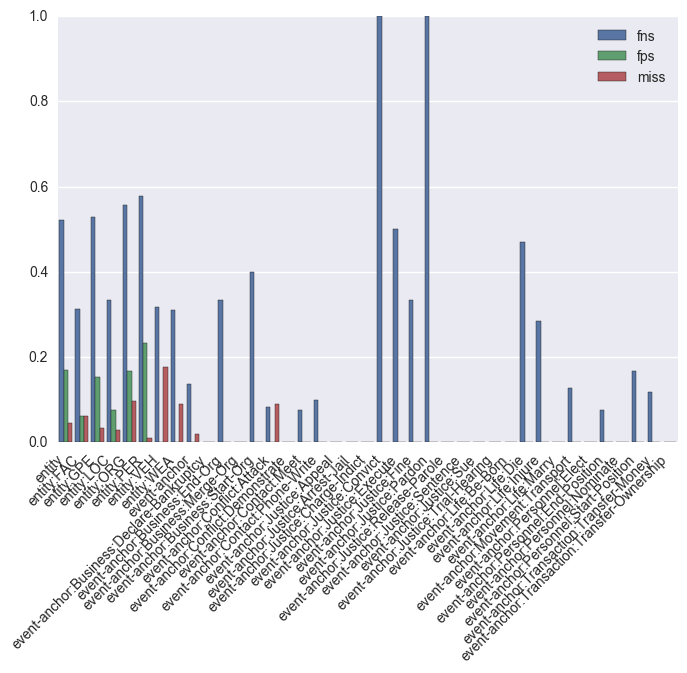

In [25]:
ax = sb.barplot(x='dtype', y='unk', hue='class', data=unks)
plt.xticks(rotation=45, ha='right')

# How balanced are the UNKs in the data splits?

In [6]:
ls experiments

extractor_100_0.25_100_180.model
extractor_100_0.25_100_180_config.json
extractor_100_0.25_100_180_eval_stats.json
extractor_100_0.25_100_180_report_stats.json
extractor_50_0.25_100_100.model
extractor_50_0.25_100_100_config.json
extractor_50_0.25_100_100_eval_stats.json
extractor_50_0.25_100_100_report_stats.json
extractor_50_0.25_100_180.model
extractor_50_0.25_100_180_config.json
extractor_50_0.25_100_180_eval_stats.json
extractor_50_0.25_100_180_report_stats.json
extractor_50_0.25_100_200.model
extractor_50_0.25_100_200_config.json
extractor_50_0.25_100_200_eval_stats.json
extractor_50_0.25_100_200_report_stats.json
extractor_50_0.25_100_200_stats.json
extractor_50_0.25_1_100.model
extractor_50_0.25_1_100_config.json
extractor_50_0.25_1_100_eval_stats.json
extractor_50_0.25_1_100_report_stats.json
extractor_50_0.25_200_100.model
extractor_50_0.25_200_100_stats.json
extractor_50_0.25_200_200.model
extractor_50_0.25_200_200_eval_stats.json
extractor_50_0.25_200_200_report_stats.json


In [7]:
arg_dict = {'tagger_f':'tagger__50_100_simple_0.5_30_300_0.0001_glove.6B.200d.txt'}
dataset, tagger = load_dataset_and_tagger(arg_dict)

Loading stats
Tagger args:  {u'count': 2, u'grad_clip': 50.0, u'use_mlp': False, u'embedding_size': 200, u'use_hdropout': False, u'map_func_name': u'Entity_typed_BIO_map', u'model_f': u'', u'n_epoch': 30, u'learning_rate': 0.01, u'n_layers': 1, u'lstm_size': 100, u'batch_size': 300, u'rseed': 42, u'crf_type': u'simple', u'w2v_fname': u'data/word_vectors/glove.6B.200d.txt', u'bidirectional': False, u'weight_decay': 0.0001, u'dropout': 0.5, u'eval_only': False, u'wait': 20}
Loading data...
Boundary vocab:
	0:: <PAD>
	1:: <UNK>
	2:: B-entity-FAC
	3:: B-entity-GPE
	4:: B-entity-LOC
	5:: B-entity-ORG
	6:: B-entity-PER
	7:: B-entity-VEH
	8:: B-entity-WEA
	9:: I-entity-FAC
	10:: I-entity-GPE
	11:: I-entity-LOC
	12:: I-entity-ORG
	13:: I-entity-PER
	14:: I-entity-VEH
	15:: I-entity-WEA
	16:: O
Mention vocab:
	0:: <PAD>
	1:: <UNK>
	2:: entity:FAC
	3:: entity:GPE
	4:: entity:LOC
	5:: entity:ORG
	6:: entity:PER
	7:: entity:VEH
	8:: entity:WEA
	9:: event-anchor:Business:Declare-Bankruptcy
	10:: ev

In [1]:
from infonet.preprocess import get_ace_extraction_data

In [2]:
dataset = get_ace_extraction_data(count=0)

Loading data...
Boundary vocab:
	0:: <PAD>
	1:: <UNK>
	2:: B
	3:: I
	4:: O
Mention vocab:
	0:: <PAD>
	1:: <UNK>
	2:: entity:FAC
	3:: entity:GPE
	4:: entity:LOC
	5:: entity:ORG
	6:: entity:PER
	7:: entity:VEH
	8:: entity:WEA
	9:: event-anchor:Business:Declare-Bankruptcy
	10:: event-anchor:Business:End-Org
	11:: event-anchor:Business:Merge-Org
	12:: event-anchor:Business:Start-Org
	13:: event-anchor:Conflict:Attack
	14:: event-anchor:Conflict:Demonstrate
	15:: event-anchor:Contact:Meet
	16:: event-anchor:Contact:Phone-Write
	17:: event-anchor:Justice:Acquit
	18:: event-anchor:Justice:Appeal
	19:: event-anchor:Justice:Arrest-Jail
	20:: event-anchor:Justice:Charge-Indict
	21:: event-anchor:Justice:Convict
	22:: event-anchor:Justice:Execute
	23:: event-anchor:Justice:Extradite
	24:: event-anchor:Justice:Fine
	25:: event-anchor:Justice:Pardon
	26:: event-anchor:Justice:Release-Parole
	27:: event-anchor:Justice:Sentence
	28:: event-anchor:Justice:Sue
	29:: event-anchor:Justice:Trial-Hearing
	

In [3]:
token_vocab = dataset['token_vocab']
x_train = [token_vocab.token(i) for xs in dataset['ix_train'] for i in xs]
x_dev = [token_vocab.token(i) for xs in dataset['ix_dev'] for i in xs]
x_test = [token_vocab.token(i) for xs in dataset['ix_test'] for i in xs]

In [4]:
print float(len([x for x in x_train if x == '<UNK>']))/len(x_train)
print float(len([x for x in x_dev if x == '<UNK>']))/len(x_dev)
print float(len([x for x in x_test if x == '<UNK>']))/len(x_test)

0.0568785460793
0.0568104519973
0.0559974290994


# What is distributions of edge types by length?

In [1]:
from infonet.preprocess import get_ace_extraction_data

In [2]:
dataset = get_ace_extraction_data(count=0, oversample_unks=True, map_func_name='E_BIO_map',
                                  train_vocab_only=False,
                                 data_dir='data/ACE 2005/yaat_coref/')

Loading data...
351 train, 80 dev, and 80 test documents
Oversampling training unks from 0.0% to 0.0%
Resulting sampled ratios: Train:0.0%, Dev:0.0%
train 2048, dev 1577, test 1537 max dists


In [3]:
rs = dataset['r_train']

In [4]:
print rs[0]

[(83, 84, 84, 85, u'relation:<-GEN-AFF--'), (60, 61, 64, 65, u'relation:--PHYS->'), (69, 70, 71, 72, u'event-argument:<-ARG:Defendant--'), (91, 92, 93, 94, u'event-argument:<-ARG:Target--'), (43, 44, 47, 48, u'coref:--SameAs--'), (43, 44, 52, 53, u'coref:--SameAs--'), (47, 48, 52, 53, u'coref:--SameAs--'), (57, 59, 60, 61, u'coref:--SameAs--'), (57, 59, 69, 70, u'coref:--SameAs--'), (60, 61, 69, 70, u'coref:--SameAs--'), (85, 87, 91, 92, u'coref:--SameAs--'), (43, 44, 56, 57, u'--NULL--'), (43, 44, 57, 59, u'--NULL--'), (43, 44, 60, 61, u'--NULL--'), (43, 44, 64, 65, u'--NULL--'), (43, 44, 69, 70, u'--NULL--'), (43, 44, 71, 72, u'--NULL--'), (43, 44, 83, 84, u'--NULL--'), (43, 44, 84, 85, u'--NULL--'), (43, 44, 85, 87, u'--NULL--'), (43, 44, 91, 92, u'--NULL--'), (43, 44, 93, 94, u'--NULL--'), (47, 48, 56, 57, u'--NULL--'), (47, 48, 57, 59, u'--NULL--'), (47, 48, 60, 61, u'--NULL--'), (47, 48, 64, 65, u'--NULL--'), (47, 48, 69, 70, u'--NULL--'), (47, 48, 71, 72, u'--NULL--'), (47, 48, 

In [7]:
r_dists = [(r[4], r[2]-r[1]) for s in rs for r in s]
r2dists = {}
for r in r_dists:
    if r[0] in r2dists:
        r2dists[r[0]].append(r[1])
    else:
        r2dists[r[0]] = [r[1]]

In [11]:
print r2dists.keys()

[u'relation:--PHYS->', u'event-argument:<-ARG:Beneficiary--', u'event-argument:--ARG:Recipient->', u'--NULL--', u'event-argument:<-ARG:Target--', u'relation:--PER-SOC->', u'event-argument:--ARG:Entity->', u'relation:<-PHYS--', u'event-argument:--ARG:Destination->', u'event-argument:--ARG:Artifact->', u'coref:--SameAs--', u'event-argument:--ARG:Beneficiary->', u'event-argument:--ARG:Plaintiff->', u'event-argument:<-ARG:Entity--', u'relation:--PART-WHOLE->', u'event-argument:--ARG:Victim->', u'event-argument:<-ARG:Person--', u'event-argument:--ARG:Defendant->', u'relation:<-ART--', u'event-argument:<-ARG:Vehicle--', u'event-argument:<-ARG:Org--', u'event-argument:<-ARG:Defendant--', u'event-argument:<-ARG:Agent--', u'relation:--ORG-AFF->', u'relation:<-GEN-AFF--', u'relation:--GEN-AFF->', u'relation:--ART->', u'event-argument:<-ARG:Destination--', u'event-argument:<-ARG:Place--', u'event-argument:<-ARG:Adjudicator--', u'relation:<-PER-SOC--', u'event-argument:<-ARG:Victim--', u'event-arg

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()

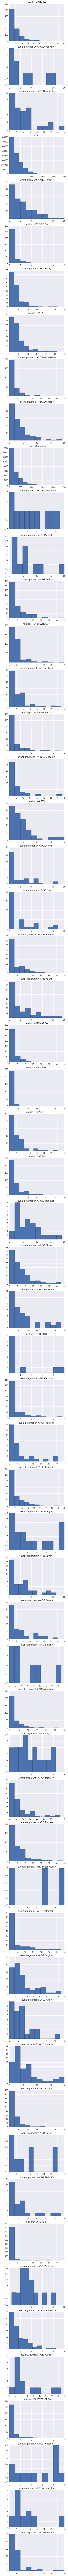

In [15]:
fig, axs = plt.subplots(len(r2dists), figsize=(5,4*len(r2dists)))
for i, (r, lens) in enumerate(r2dists.items()):
    axs[i].hist(lens)
    axs[i].set_title(r)

 So basically all but some of thee event arguments are almost always below 20 or so.
 
 ## What proportion of mass, excluding coref sits below a max dists threshold?

In [24]:
def data_maxdist_stats(max_dist, show_all=False):
    total_c, total = 0, 0
    for r, lens in r2dists.items():
        c = len([l for l in lens if l <= max_dist])
        if show_all: print "{0}: {1}/{2} = {3:2.4f}%".format(r, c, len(lens), 100.*float(c)/len(lens))
        if r not in ('--NULL--', 'coref:--SameAs--'):
            total_c += c
            total += len(lens)

    null_c = len([l for l in r2dists['--NULL--'] if l <= max_dist])
    null_total = len(r2dists['--NULL--'])
    print "{}/{} not null, {}/{} null".format(total_c, total, null_c, null_total)
    print "{0:2.2f}% of examples would be not null".format(100.*total_c/float(total_c+null_c))

In [25]:
for max_dist in [10,20,25,30]:
    print max_dist, '*'*80
    data_maxdist_stats(max_dist)

10 ********************************************************************************
7717/8383 not null, 46283/1738602 null
14.29% of examples would be not null
20 ********************************************************************************
8249/8383 not null, 93048/1738602 null
8.14% of examples would be not null
25 ********************************************************************************
8331/8383 not null, 116274/1738602 null
6.69% of examples would be not null
30 ********************************************************************************
8358/8383 not null, 139302/1738602 null
5.66% of examples would be not null
